## Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR

In [16]:
import sys
sys.path.append('..')

from src.generators import LSTMGenerator
from src.training import train, plot_metric_curves, LearningRateCallback, save_model, log_loss_seq
from src.training import SetupsDataset, SetupsDatasetWrapper
from src.plotting import create_plot_grid

## Tuning parameters and number of epochs using cross-validation

In [ ]:
setups_df = pd.read_csv("../data/setups.csv", header=None, dtype='uint8').drop_duplicates().reset_index(drop=True)
setups_dataset = SetupsDataset(setups_df.to_numpy())

In [ ]:
criterion =  nn.CrossEntropyLoss()
num_epochs = 30
batch_size = 128

num_folds = 5
seed = 1
mirror_prob = 0.4

In [19]:
model_params = {"hidden_size": 256,
                "embedding_dim": 8,
                "num_layers": 2
                }

In [20]:
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

training_history = []

torch.manual_seed(seed)


for fold_number, (train_indices, val_indices) in enumerate(kfold.split(setups_dataset)):

    print(f"fold {fold_number + 1}")

    model = LSTMGenerator(**model_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

    train_dataset_wrapper = SetupsDatasetWrapper(setups_dataset, mirror_prob=mirror_prob, random_state=seed)
    val_dataset_wrapper = SetupsDatasetWrapper(setups_dataset)

    train_dataloader = DataLoader(Subset(train_dataset_wrapper, train_indices), batch_size=batch_size, shuffle=True,
                                  generator=torch.Generator().manual_seed(seed))
    val_dataloader = DataLoader(Subset(val_dataset_wrapper, val_indices), batch_size=batch_size, shuffle=False)

    metrics_per_epoch = train(model, train_dataloader, num_epochs, optimizer, criterion,
                              val_dataloader, eval_metrics=[("Cross Entropy", log_loss_seq)],
                              callbacks=[LearningRateCallback(lr_scheduler, verbose=True)])

    training_history.append(metrics_per_epoch)


mean_train_metric = np.mean([training_history[fold]["train_metrics"]["Cross Entropy"] for fold in range(num_folds)], axis=0)
mean_val_metric = np.mean([training_history[fold]["val_metrics"]["Cross Entropy"] for fold in range(num_folds)], axis=0)
best_epoch = np.argmin(mean_val_metric)
best_score = mean_val_metric[best_epoch]

print("----------------------------------")
print(f"best epoch {best_epoch}")
print(f"best mean score {best_score}")

fold 1
Using device 'cuda'
Epoch: 1, Train Cross Entropy: 1.73798, Val Cross Entropy: 1.73829
Learning Rate: [0.0095]
Epoch: 2, Train Cross Entropy: 1.62236, Val Cross Entropy: 1.62699
Learning Rate: [0.009025]
Epoch: 3, Train Cross Entropy: 1.5755, Val Cross Entropy: 1.58499
Learning Rate: [0.00857375]
Epoch: 4, Train Cross Entropy: 1.55777, Val Cross Entropy: 1.57085
Learning Rate: [0.0081450625]
Epoch: 5, Train Cross Entropy: 1.52881, Val Cross Entropy: 1.54743
Learning Rate: [0.007737809374999999]
Epoch: 6, Train Cross Entropy: 1.51683, Val Cross Entropy: 1.53773
Learning Rate: [0.007350918906249998]
Epoch: 7, Train Cross Entropy: 1.50244, Val Cross Entropy: 1.52707
Learning Rate: [0.006983372960937498]
Epoch: 8, Train Cross Entropy: 1.48425, Val Cross Entropy: 1.51647
Learning Rate: [0.006634204312890623]
Epoch: 9, Train Cross Entropy: 1.47616, Val Cross Entropy: 1.5132
Learning Rate: [0.006302494097246091]
Epoch: 10, Train Cross Entropy: 1.4635, Val Cross Entropy: 1.50743
Learnin

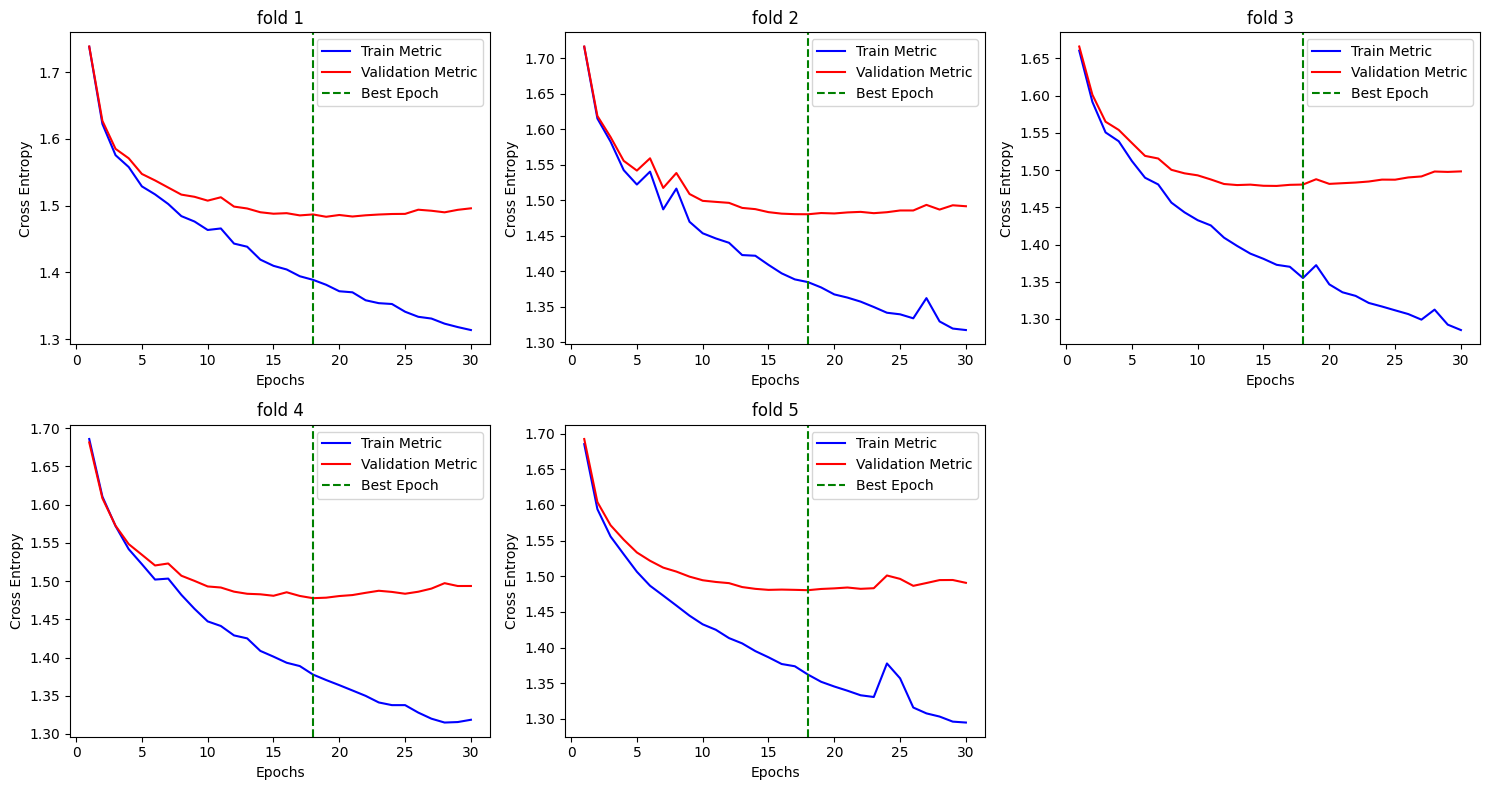

In [21]:
num_plot_columns = 3
fig, axes = create_plot_grid(num_folds, num_plot_columns, subplot_width=5, subplot_height=4)

for fold in range(num_folds):
    row, column = divmod(fold, num_plot_columns)
    plot_metric_curves(training_history[fold]["train_metrics"]["Cross Entropy"],
                       training_history[fold]["val_metrics"]["Cross Entropy"],
                       best_epoch=best_epoch+1,
                       title=f"fold {fold+1}", ax=axes[row][column], metric_label="Cross Entropy")

for i in range(num_folds, len(fig.axes)):
    row, column = divmod(i, num_plot_columns)
    axes[row][column].axis('off')

plt.tight_layout()

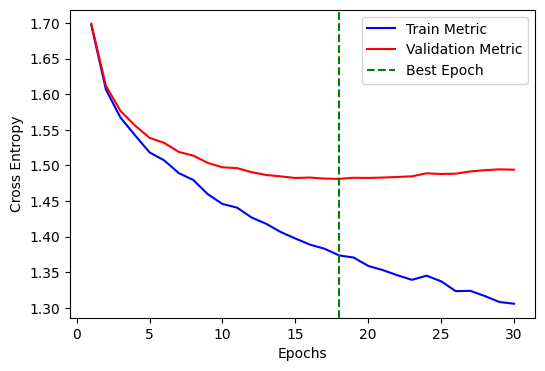

In [22]:
plot_metric_curves(mean_train_metric, mean_val_metric, best_epoch=best_epoch+1, metric_label="Cross Entropy")

## Model training

In [23]:
criterion =  nn.CrossEntropyLoss()
num_epochs = 20
batch_size = 128
seed = 1

In [24]:
torch.manual_seed(seed)

model = LSTMGenerator(**model_params)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

train_dataset_wrapper = SetupsDatasetWrapper(setups_dataset, mirror_prob=mirror_prob, random_state=seed)
train_dataloader = DataLoader(train_dataset_wrapper, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(seed))

metrics_per_epoch = train(model, train_dataloader, num_epochs, optimizer, criterion,
                          eval_metrics=[("Cross Entropy", log_loss_seq)],
                          callbacks=[LearningRateCallback(lr_scheduler, verbose=True)])

Using device 'cuda'
Epoch: 1, Train Cross Entropy: 1.65331
Learning Rate: [0.0095]
Epoch: 2, Train Cross Entropy: 1.59129
Learning Rate: [0.009025]
Epoch: 3, Train Cross Entropy: 1.57532
Learning Rate: [0.00857375]
Epoch: 4, Train Cross Entropy: 1.54138
Learning Rate: [0.0081450625]
Epoch: 5, Train Cross Entropy: 1.51583
Learning Rate: [0.007737809374999999]
Epoch: 6, Train Cross Entropy: 1.49745
Learning Rate: [0.007350918906249998]
Epoch: 7, Train Cross Entropy: 1.48632
Learning Rate: [0.006983372960937498]
Epoch: 8, Train Cross Entropy: 1.46709
Learning Rate: [0.006634204312890623]
Epoch: 9, Train Cross Entropy: 1.46898
Learning Rate: [0.006302494097246091]
Epoch: 10, Train Cross Entropy: 1.49303
Learning Rate: [0.005987369392383786]
Epoch: 11, Train Cross Entropy: 1.44513
Learning Rate: [0.005688000922764597]
Epoch: 12, Train Cross Entropy: 1.43848
Learning Rate: [0.005403600876626367]
Epoch: 13, Train Cross Entropy: 1.42351
Learning Rate: [0.005133420832795048]
Epoch: 14, Train Cr

## Save model

In [25]:
save_path = f"../models/lstm_generator.pth"
save_model(save_path, model, model_params=model_params)